In [1]:
# call __init_ to set notebook seed
import set_notebook_env
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import statsmodels.formula.api as smf
from scipy.stats import mannwhitneyu
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from utils.modeling_helpers import ModelHelper
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA


from collections import defaultdict
import numpy as np

import set_notebook_env
loader, plot_utils = set_notebook_env.set_env(
    data_dir="../data/", 
    min_ratings=0, 
    max_ratings=None,
    drop_inconsistent_gender = True
)

SEED = np.random.get_state()[1][0]

loader.initial_setup()
loader.add_tag_intensity_score()
prepared_df = loader.add_gender_code(loader.prepared_df)
tag_columns = loader.tag_cols
prepared_df.columns

tag_intensity_score = loader.find_agg_tag_columns("tag_intensity_score")
loader.add_column_zscores_standardized(columns = tag_intensity_score)
z_score_cols = loader.find_agg_tag_columns("zscore_tag_intensity_")
z_score_cols

prepared_df = loader.prepared_df

MODEL_HELPER = ModelHelper(df=prepared_df, random_seed=SEED)


Using seed: 18787288


In [2]:
#  Build a regression model predicting average rating from all numerical predictors (the ones in the 
# rmpCapstoneNum.csv) file. Make sure to include the R2 and RMSE of this model. Which of these 
# factors is most strongly predictive of average rating? Hint: Make sure to address collinearity concerns. 

prepared_df["avg_rating"].describe()

count    52088.000000
mean         3.845847
std          1.115058
min          1.000000
25%          3.100000
50%          4.200000
75%          4.800000
max          5.000000
Name: avg_rating, dtype: float64

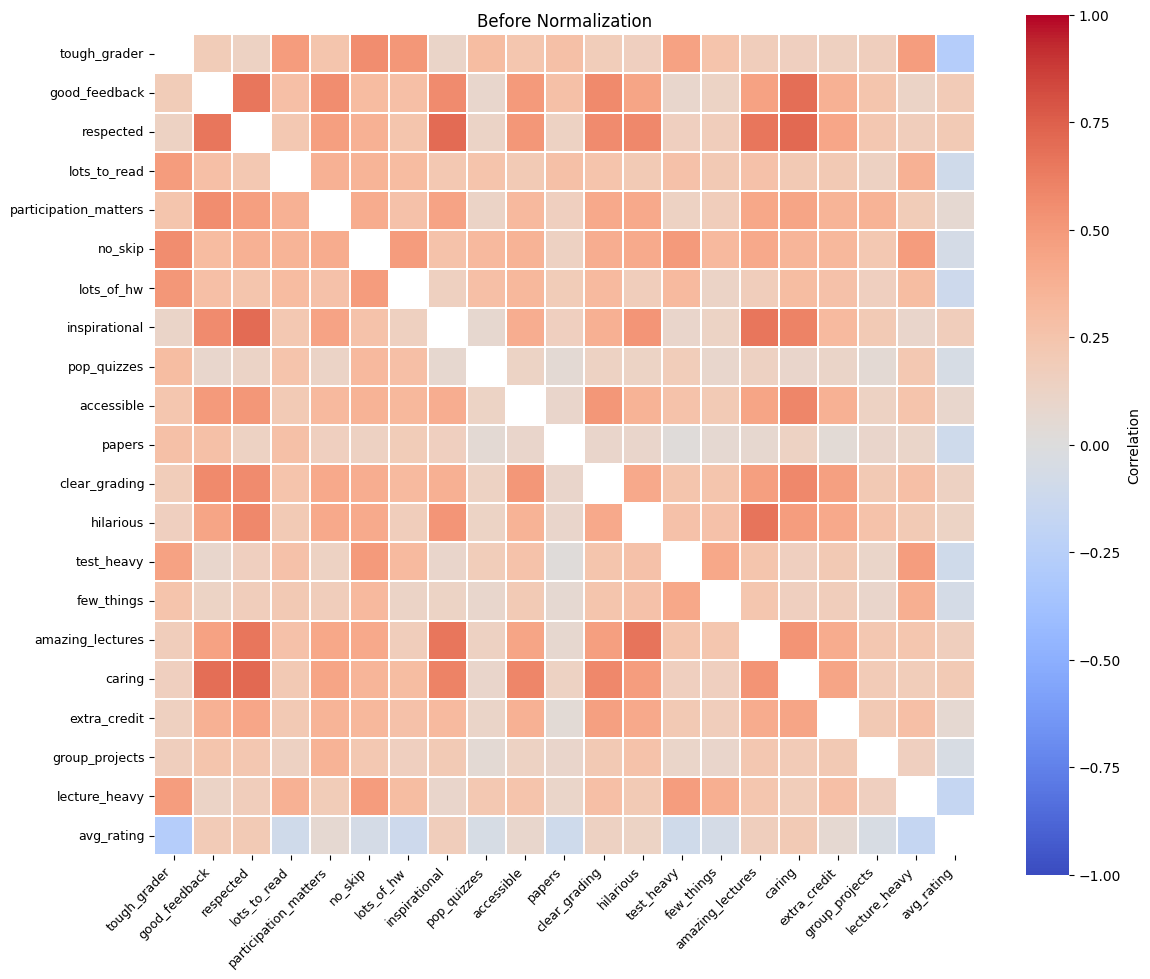

In [3]:
tag_cols = tag_columns + ["avg_rating"]
corr_matrix = prepared_df[tag_cols].corr()
diag_mask = np.eye(len(corr_matrix), dtype=bool)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    mask=diag_mask,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.3,
    fmt="",
    cbar_kws={"label": "Correlation"}
)


plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(fontsize=9)
plt.title("Before Normalization")
plt.tight_layout()
plt.show()



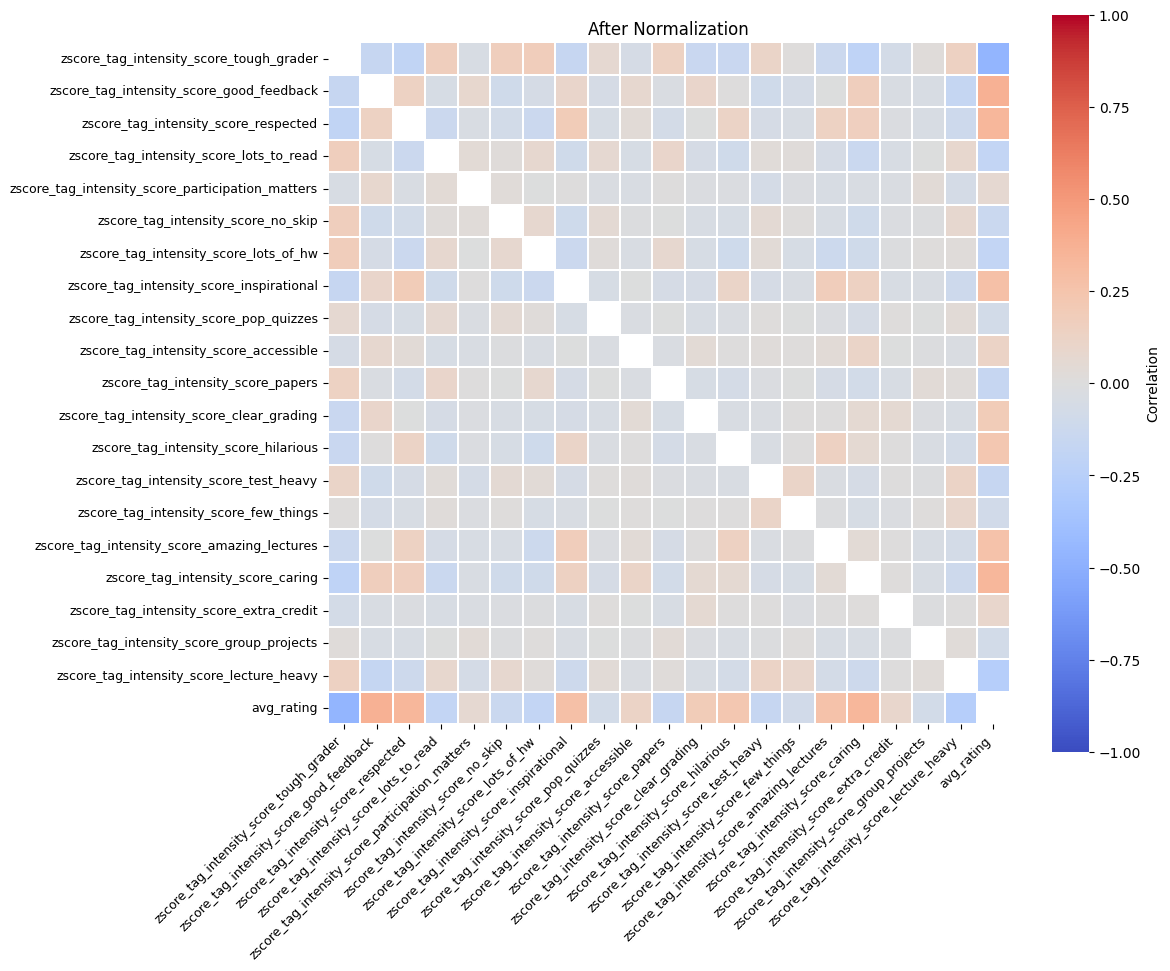

In [4]:
tag_cols = z_score_cols + ["avg_rating"]
corr_matrix = prepared_df[tag_cols].corr()
diag_mask = np.eye(len(corr_matrix), dtype=bool)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    mask=diag_mask,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.3,
    fmt="",
    cbar_kws={"label": "Correlation"}
)


plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(fontsize=9)
plt.title("After Normalization")
plt.tight_layout()
plt.show()



In [18]:
pca = PCA(n_components=17)

Y = prepared_df['avg_rating']
X = prepared_df[z_score_cols]

X_pca = pca.fit_transform(X)

X_pca_df = pd.DataFrame(
    X_pca,
    index=prepared_df.index,
    columns=[f"PC{i+1}" for i in range(X_pca.shape[1])]
)

df_pca = pd.concat([Y, X_pca_df], axis=1)
df_pca.head()

explained_var = pca.explained_variance_ratio_
pcs = np.arange(1, len(explained_var) + 1)


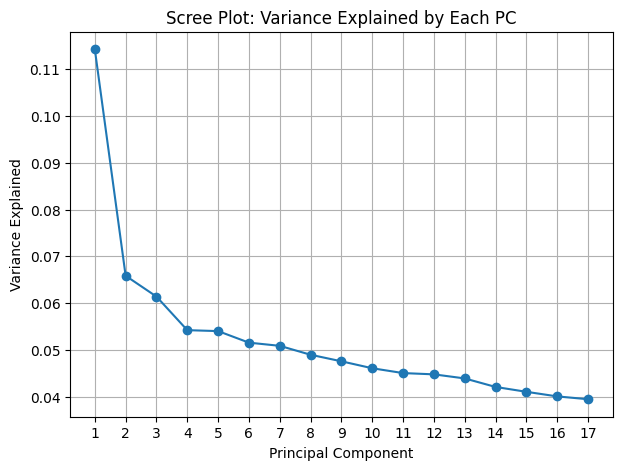

In [19]:
plt.figure(figsize=(7, 5))
plt.plot(pcs, explained_var, marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.title("Scree Plot: Variance Explained by Each PC")
plt.xticks(pcs)
plt.grid(True)
plt.show()

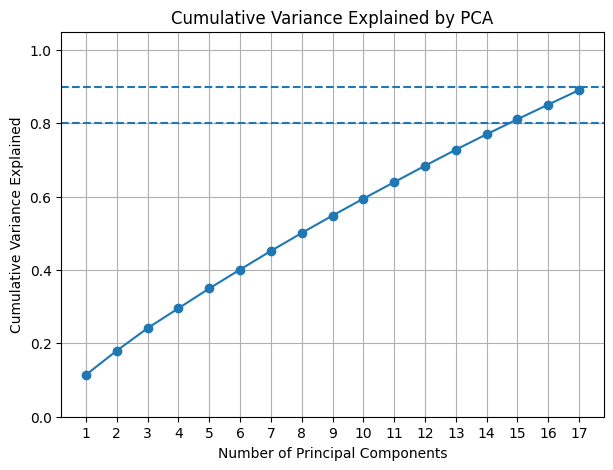

In [20]:
cum_var = np.cumsum(explained_var)

plt.figure(figsize=(7, 5))
plt.plot(pcs, cum_var, marker='o')
plt.axhline(0.8, linestyle='--')
plt.axhline(0.9, linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.title("Cumulative Variance Explained by PCA")
plt.xticks(pcs)
plt.ylim(0, 1.05)
plt.grid(True)
plt.show()


In [21]:
k_folds = MODEL_HELPER.kfold_split()

model=LinearRegression()

res = MODEL_HELPER.cross_val_score(
    model,
    X=X_pca, # X_pca_full[:-1]
    y=Y,
    kfolds=k_folds,
    scoring_methods=["rmse", "r2", "mae"]
)

print(sum(res["rmse"]) / 5, np.var(res["rmse"], ddof=1), np.std(res["rmse"], ddof=1))
print(sum(res["r2"]) / 5, np.var(res["r2"], ddof=1), np.std(res["r2"], ddof=1))

0.7922339184979557 4.557624062925151e-05 0.006751017747662311
0.4951363639835085 2.3500747480359176e-05 0.004847756953515634


In [26]:
# corr_with_y = corr_matrix["avg_rating"].abs().sort_values(ascending=False)
# selected_features = corr_with_y[corr_with_y > 0.15].index.drop("avg_rating")

# print(selected_features)

k_folds = MODEL_HELPER.kfold_split()

model=LinearRegression()

res = MODEL_HELPER.cross_val_score(
    model,
    X=X,
    y=prepared_df["avg_rating"],
    kfolds=k_folds,
    scoring_methods=["rmse", "r2", "mae"]
)

print(sum(res["rmse"]) / 5, np.var(res["rmse"], ddof=1), np.std(res["rmse"], ddof=1))
print(sum(res["r2"]) / 5, np.var(res["r2"], ddof=1), np.std(res["r2"], ddof=1))

0.7904052786056888 4.814464128728206e-05 0.00693863396406541
0.4974673969901236 2.1730808508133036e-05 0.004661631528567336


In [ ]:
top_scores = {}

for i, f in enumerate(res["fitted_models"]):
    coefs = pd.Series(
        f.coef_,  # or pipeline.named_steps["lr"].coef_
        index=z_score_cols
    ).sort_values(key=np.abs, ascending=False)

    feat = coefs.head(5)
    top_scores[i] = feat
  
top_scores  


coef_df = []

for fold, series in top_scores.items():
    tmp = series.reset_index()
    tmp.columns = ["feature", "coef"]
    tmp["abs_coef"] = tmp["coef"].abs()
    tmp["fold"] = fold
    coef_df.append(tmp)

coef_df = pd.concat(coef_df, ignore_index=True)
coef_df

summary = (
    coef_df
    .groupby("feature")
    .agg(
        mean_abs_coef=("abs_coef", "mean"),
        times_in_least5=("feature", "count")
    )
    .sort_values("mean_abs_coef", ascending=False)
)

summary

{0: zscore_tag_intensity_score_tough_grader       -0.276360
 zscore_tag_intensity_score_good_feedback       0.247999
 zscore_tag_intensity_score_caring              0.175712
 zscore_tag_intensity_score_respected           0.173932
 zscore_tag_intensity_score_amazing_lectures    0.167854
 dtype: float64,
 1: zscore_tag_intensity_score_tough_grader       -0.272645
 zscore_tag_intensity_score_good_feedback       0.248914
 zscore_tag_intensity_score_caring              0.178757
 zscore_tag_intensity_score_respected           0.177302
 zscore_tag_intensity_score_amazing_lectures    0.169306
 dtype: float64,
 2: zscore_tag_intensity_score_tough_grader       -0.277897
 zscore_tag_intensity_score_good_feedback       0.248078
 zscore_tag_intensity_score_respected           0.180436
 zscore_tag_intensity_score_caring              0.180303
 zscore_tag_intensity_score_amazing_lectures    0.168655
 dtype: float64,
 3: zscore_tag_intensity_score_tough_grader       -0.276336
 zscore_tag_intensity_sco

In [29]:
least_scores = {}

for i, f in enumerate(res["fitted_models"]):
    coefs = pd.Series(
        f.coef_,  # or pipeline.named_steps["lr"].coef_
        index=z_score_cols
    ).sort_values(key=np.abs, ascending=False)

    feat = coefs.tail(5)
    least_scores[i] = feat  


coef_df = []

for fold, series in least_scores.items():
    tmp = series.reset_index()
    tmp.columns = ["feature", "coef"]
    tmp["abs_coef"] = tmp["coef"].abs()
    tmp["fold"] = fold
    coef_df.append(tmp)

coef_df = pd.concat(coef_df, ignore_index=True)
coef_df

summary = (
    coef_df
    .groupby("feature")
    .agg(
        mean_abs_coef=("abs_coef", "mean"),
        times_in_least5=("feature", "count")
    )
    .sort_values("mean_abs_coef", ascending=False)
)

summary



,mean_abs_coef,times_in_least5
feature,,
zscore_tag_intensity_score_few_things,0.039526,3
zscore_tag_intensity_score_lots_of_hw,0.036560,3
zscore_tag_intensity_score_lots_to_read,0.030175,5
zscore_tag_intensity_score_group_projects,0.028922,4
zscore_tag_intensity_score_pop_quizzes,0.007972,5
zscore_tag_intensity_score_no_skip,0.003011,5
